# diffusion model (Explicit)

    ↪ 원본 데이터에 noise를 주입하는 diffusion process와, noise를 제거하여 원본을 복원하는 reverse process로 구성된 생성모델

    1) diffusion process : Px(x) --> Pz(Z)
        ▢ 노이즈를 주입하여 패턴을 무너뜨림(noising)
        ▢ Iterative Markov chain : q(z|x) ==> Σq(Xt|Xt-1) : x1 ~ xt 모두 latent variable
            ↪ diffusion process는 학습하지 않음
    
    2) reverse process : Pz(z) --> P'x(x)
        ▢ 패턴을 다시 복원하는 조건부 pdf를 학습(denoising)
        ▢ Iterative Markov chain : pθ(x|z)
            ↪ 이전의 상태(t-1)에만 의존해서 다음 상태(t) 확률을 예측하여 학습

        ✔ x_tilde = αx + (1-α)ε

            α : 추가되는 노이즈의 양을 결정하는 스칼라. x와 noise의 비율. alpha = 1-beta이며, 현재 시간 단계까지의 노이즈는 누적곱인 (cumprod(alpha))를 alpha_bars로 사용함.
            ε : 평균이 0이고 분산이 1인 정규분포에서 샘플링된 noise


#### ▢ DDPM(Denoising Diffusion Probabilistic Models)
    ↪ diffusion model에서 발생한 문제점들을 보완하고 개선하여 만든 모델

    ✔ 기존 diffusion
        1) 원본 데이터(X(i))에서 noise가 추가된 X(i+1)를 예측

        2) loss = regularization loss(KL divergence) + reconstruction loss(MSELoss)

    ✔ DDPM
        1) DDPM에서는 ResNet처럼 residual(모델로 예측된 noise)를 예측하여 학습을 안정화시키고 성능을 향상시킴.

        2)loss = reconstruction loss(MSELoss)
        (regularization을 없앰 : 기존에 학습하던 beta t를 constant로 fix해서 regularization loss를 상수로 만듦)
        ↪  inductive bias를 추가하는 방향으로 contribution이 진행됨

            ✔ Inductive bias
                ↪ 모델이 학습하지 않은 데이터에 대해 추론할 때 참고하는 가정/편향이다.
                (모델에 모든 학습을 맡기지 말고 사람의 사전지식이 해결 가능한 부분은 제외시키자)

        3)
        variance를 학습하지 않음


    https://www.youtube.com/watch?v=_JQSMhqXw-4
    https://www.youtube.com/watch?v=1j0W_lu55nc

# score-based model (Implicit)
    ↪ 입력 공간의 각 데이터 포인트에 "score"를 할당하는 방법을 학습.
        score는 모델이 학습한 데이터 분포에 따라 특정 데이터 포인트가 얼마나 가능성이 있는지를 나타냄.
    
    ✔ score : x(input data) 확률 분포의 x에 대한 기울기
        ▢ ▽x log p(x) = log p(x)의 x에 대한 gradient = x에 대한 로그 확률분포를 x로 편미분한 것 = x의 변화 정도에 따른 log p(x)의 변화량
        ▢ 원래는 통계에서 ▽θ log p(θ)로 사용하던 score 개념에 데이터를 넣은 것
        ▢ Maximum log likelyhood estimation에서, θ=0일 때 local maximum을 만족하게 됨(generative model에서 이미 사용하고 있던 개념)
        ▢ 분포 자체보다는 데이터 분포의 기울기를 학습하는데 중점을 둠.
        ▢ 특정 지점의 score는 확률 밀도 그 자체가 높은 것 보다는 확률 밀도가 증가하는 정도가 가장 큰 비율과 방향을 나타냄

    ✔ score를 사용하는 이유
        ▢ pdf는 sum-to-one이라는 function의 정의를 반드시 따라야 하는 개념인데, 실제 데이터의 분포에 모델의 분포를 근사시키려면 zθ(normalization factor)도 같이 모델링을 해줘야 함. 그러나 Zθ를 모델링하는 것이 어려움.
        ▢ pdf ==> pθ(x) = e^(-fθ(x))/Zθ
        ▢ score-function의 경우 이런 제약 조건이 없음. x로 편미분을 하게 되면 Zθ에 해당하는 항은 0이 되기 때문(Zθ을 모델링할 필요가 없어짐)

    ✔ score model(sθ(x))로 Pdata의 expectation을 유도하는 방법
        ▢ ▽x log p(x)에서 gradient를 매칭하려면 p(x)를 알아야 함
        ▢ ▽θ log p(θ)에 sθ(x) (score model)와의 평균 유클리드 거리를 계산하여 근사시킴 ==> fisher divergence
        ▢ 근데 문제는 ▽x log Pdata(x)에서 criteria가 되줄 Pdata(x)를 모름. ==> integration by parts로 우회해서 해결 가능
        ▢ 결론적으로 score model(sθ(x)) 만 알면 Pdata의 expectation을 유도할 수 있음

    ✔ score가 잘 define이 안되는 경우
        1) 대부분의 이미지는 특징 없이 비어있는 공간이 너무 많기 때문에 score define이 잘 안됨
        2) gradient를 사용하는 방법이므로 discrete한 데이터의 경우 score define이 잘 안됨
            ↪ noise를 더해서 해결

        3) slow mixing of Langevin dynamics : low density(데이터가 없는 범위의 영역, high density : 대부분의 training 데이터는 특정 포인트에 몰려있음)에는 해당 영역의 학습이 안되기 때문에 정확하지 않음.
            ↪  적절하게(noise 정도에 따라 trade-off발생) noise를 더해주면 support가 없는 영역에 대해서도 학습이 됨

    ✔ Annealed Langevin Dynamics
        1) noise를 많이 줘서 학습
        2) 1의 결과를 initialized state로 사용해서 noise를 약간 줄인 다음 다시 학습
        3) noise를 점차 줄여가며 반복하면 학습이 잘 됨


#### 코드 참조 : https://github.com/JeongJiHeon/ScoreDiffusionModel

In [ ]:
from tqdm import tqdm
import math
from IPython.display import HTML
from IPython.display import clear_output
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate

import torch
import torch.nn as nn
import torchvision
from torch.nn import init
from torch.nn import functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<ipython-input-1-10519fcf8a12>:10: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [ ]:
def pr(t_name, t) :
    print(f'{t_name} : {t.shape}')
    print()

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, timesteps, emb_dim, out_dim):
        """
        timesteps : 입력 시퀀스의 길이
        emb_dim : 각 임베딩 벡터의 차원. sin과 cos 함수를 사용하여 시간 정보를 인코딩
        out_dim : linear layer의 출력 차원(최종 임베딩 벡터의 차원)
        emb : sin과 cos 변환을 거쳐 변환되는 최종 임베딩(Unet에서 사용할 embedding)
        pos : 시간의 위치를 나타내는 tensor. 0부터 timesteps-1 까지의 정수 iter
        """
        assert emb_dim % 2 == 0
        super().__init__()
        emb = torch.arange(0, emb_dim, step=2) / torch.Tensor([emb_dim]) * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(timesteps).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [timesteps, emb_dim // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [timesteps, emb_dim // 2, 2]
        emb = emb.view(timesteps, emb_dim)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(emb_dim, out_dim),
            nn.GELU(),
            nn.Linear(out_dim, out_dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):           # t : [batch_size]
        emb = self.timembedding(t)  # emb : [batch_size, out_dim]
        return emb


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):     # x : [batch_size, in_ch, H, W]
        x = self.main(x)            # x : [batch_size, in_ch, H//2, W//2]
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):     # x : [batch_size, in_ch, H, W]
        _, _, H, W = x.shape
        x = F.interpolate(          # x : [batch_size, in_ch, H*2, W*2]
            x, scale_factor=2, mode='nearest')
        x = self.main(x)            # x : [batch_size, in_ch, H*2, W*2]
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):       # x : [batch_size, in_ch, H, W]
        B, C, H, W = x.shape
        h = self.group_norm(x)  # h, q, k, v : [batch_size, in_ch, H, W]
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C) # q : [batch_size, H*W, in_ch]
        k = k.view(B, C, H * W)                     # k : [batch_size, in_ch, H*W]
        w = torch.bmm(q, k) * (int(C) ** (-0.5))    # w : [batch_size, H*W, H*W]

        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)                    # w : [batch_size, H*W, H*W]

        v = v.permute(0, 2, 3, 1).view(B, H * W, C) # v : [batch_size, H*W, in_ch]
        h = torch.bmm(w, v)                         # h : [batch_size, H*W, in_ch]
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)  # h : [batch_size, in_ch, H, W]
        h = self.proj(h)                            # h : [batch_size, in_ch, H, W]
        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            nn.GELU(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            nn.GELU(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):         # x : [batch_size, in_ch, H, W], temb : [batch_size, tdim]
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)
        h = h + self.shortcut(x)
        h = self.attn(h)                # h : [batch_size, out_ch, H, W]
        return h


class UNet(nn.Module):
    def __init__(self, T, ch=128, ch_mult=[1,2,2,2], attn=[1], num_res_blocks=2, dropout=0.1):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(1, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            nn.GELU(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):            # x : [batch_size, 1, H, W], t : [batch_size]
        # Timestep embedding
        temb = self.time_embedding(t)   # temb : [batch_size, tdim]

        # Downsampling
        h = self.head(x)                # h : [batch_size, ch, H, W]
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)                # h : [batch_size, 1, H, W]
        assert len(hs) == 0
        return h

In [ ]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T):

        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = UNet(T)

        self.to(device = self.device)

    def loss_fn(self, x, idx=None):
        output, epsilon, alpha_bar = self.forward(x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss


    def forward(self, x, idx=None, get_target=False):                                               # x : [batch_size, 1, H, W]
        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)    # idx : [batch_size]
            used_alpha_bars = self.alpha_bars[idx][:, None, None, None]                             # used_alpha_bars : [batch_size, 1, 1, 1]
            epsilon = torch.randn_like(x)                                                           # epsilon : [batch_size, 1, H, W]
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon   # x_tilde : [batch_size, 1, H, W]

        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()     # idx : [batch_size]
            x_tilde = x                                                                             # x_tilde : [batch_size, 1, H, W]

        # 입력 데이터에 대한 데이터 분포의 score 예측
        output = self.backbone(x_tilde, idx)  # output : [batch_size, 1, H, W]
        return (output, epsilon, used_alpha_bars) if get_target else output


In [ ]:
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape):
        ## betas, alphas, alpha_bars, alpha_prev_bars : [ T ]
        # betas : diffusion process의 각 단계에 추가될 noise sequence
        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        # alphas : 1-betas, 원본 데이터가 유지되는 비율
        self.alphas = 1 - self.betas
        # alpha_bars : alpha의 누적곱, 원본으로부터 현재 남아있는 데이터의 비율, reverse process에서는 이전까지 제거한 noise의 양에 따라 다음 제거 할 noise의 양을 결정하는데 역할을 함
        self.alpha_bars = torch.cumprod(self.alphas, dim = 0).to(device = device)
        # alpha_prev_bars : 이전 step 까지의 alpha 누적곱.
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape

        self.diffusion_fn = diffusion_fn
        self.device = device

    def _one_diffusion_step(self, x):
        for idx in reversed(range(len(self.alpha_bars))):
            # noise : [sampling_number, 1, H, W]
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            # sqrt_tilde_beta : reverse process에서 시간 단계에 따라 scaled된 noise 가중치.
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            # predict_epsilon : 모델로 예측한 idx와 idx-1 사이에 추가된 noise, [sampling_number, 1, H, W]
            predict_epsilon = self.diffusion_fn(x, idx)
            # mu_theta_xt : noise가 추가되기 전 샘플(idx-1)의 최선의 추정치, [sampling_number, 1, H, W]
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            # x : idx-1번째 샘플이 될 x, mu_theta_xt에 randomness를 추가한 값, [sampling_number, 1, H, W]
            x = mu_theta_xt + sqrt_tilde_beta * noise

            yield x

    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        sample = torch.randn([sampling_number,*self.shape]).to(device = self.device)
        sampling_list = []

        final = None
        for sample in self._one_diffusion_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

In [ ]:
epochs = 20
batch_size = 64
sampling_number = 16
only_final = True
beta_1 = 1e-4
beta_T = 0.02
T = 500
shape = (1, 16, 16)

model = Model(device, beta_1, beta_T, T)
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
optim = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((shape[-2], shape[-1])),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.MNIST(root = './MNIST', train=True, download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True, num_workers = 0)

print(f'dataset size : {len(dataset)}')
print(f'batch size : {batch_size} / len(dataloader) : {len(dataloader)}')

100%|██████████| 9912422/9912422 [00:00<00:00, 245236686.92it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32259838.57it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 76155301.52it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5005393.79it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

dataset size : 60000
batch size : 64 / len(dataloader) : 937


In [ ]:
from torchvision.utils import save_image
def imshow(sample, epoch, sampling_number = 64):
    plt.figure(figsize=(10, 10))
    clear_output()
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255

    show_sample = show_sample.astype(np.uint8)
    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

    save_image(torch.Tensor(show_sample), f'image_{epoch}.png', nrow=5, normalize=True)

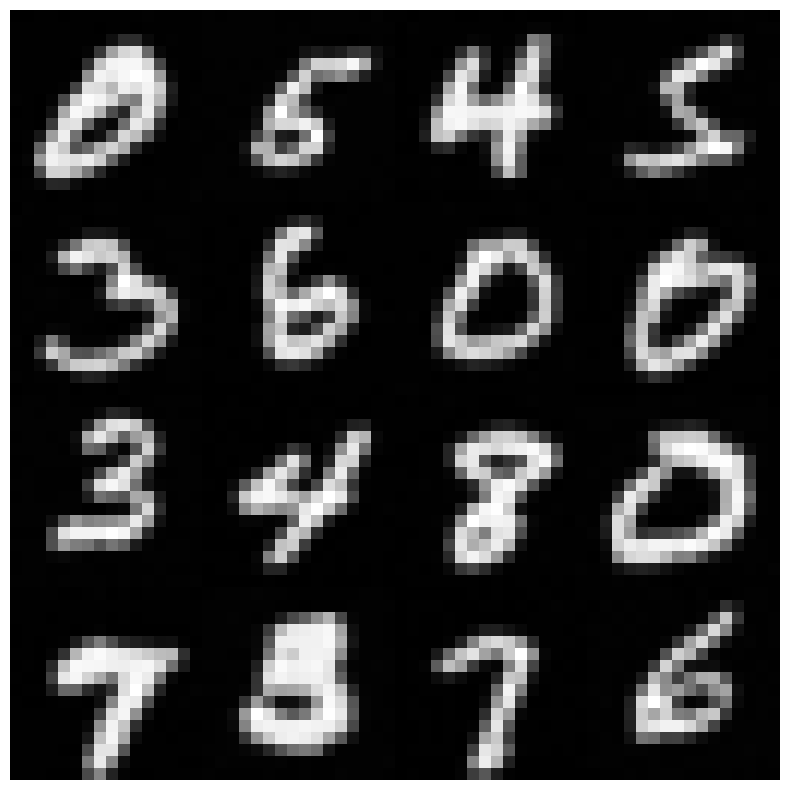

100%|██████████| 20/20 [48:24<00:00, 145.21s/it]


In [ ]:
for epoch in tqdm(range(1, epochs+1)) :
    epoch_train_loss = 0
    for data in dataloader :
        data = data[0].to(device=device)
        loss = model.loss_fn(data)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_train_loss += loss.item()
    epoch_train_loss /= len(dataloader)

    print(f"[Epoch {epoch}/{epochs}] [epoch_train_loss: {epoch_train_loss:.6f}]")

    if epoch % 2 == 0 :
        process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
        sample = process.sampling(sampling_number, only_final)
        imshow(sample, epoch, sampling_number)


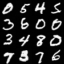

In [ ]:
from IPython.display import Image
Image('image_20.png')